,row_number,gid,cuenca,tipo_curso,nombre,nombre2,categoria,long_km,geom
0,1,1969,Cuenca del Tajo,Garganta,Garganta las Papuas,None,3,6.29165,"MULTILINESTRING ((266295.689 4456146.823, 2662..."
1,2,131,Cuenca del Tajo,Arroyo,Arroyo Majacero,None,3,2.32514,"MULTILINESTRING ((268234.682 4461243.878, 2682..."


ConnectionError: HTTPSConnectionPool(host='servicios.idee.es', port=443): Max retries exceeded with url: /wms-inspire/mdt?service=WMS&request=GetCapabilities&version=1.1.1 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f566bab1090>: Failed to establish a new connection: [Errno -2] Name or service not known'))

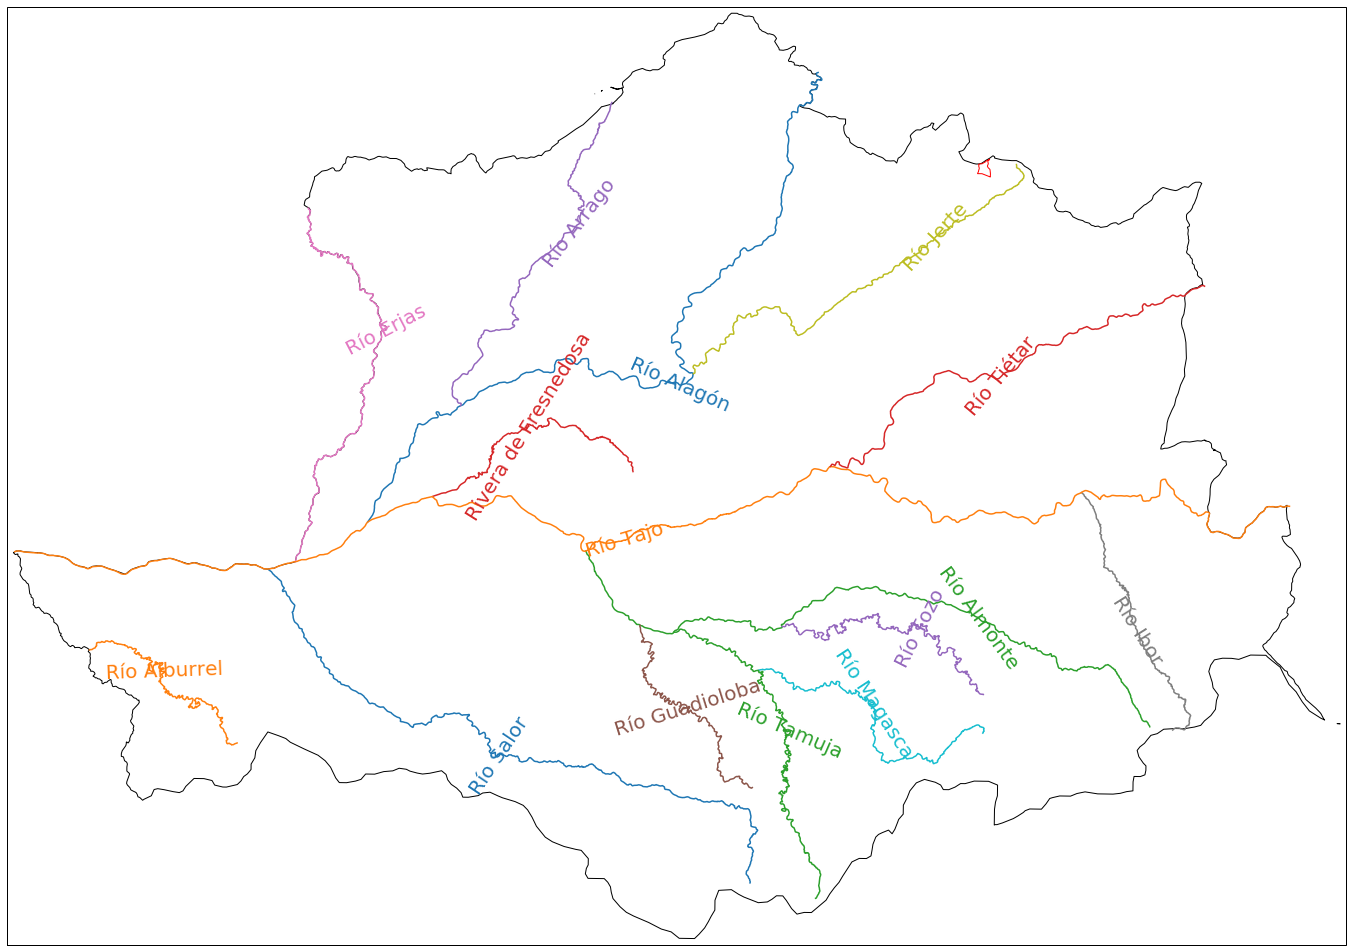

In [1]:
import psycopg2
import geopandas as gpd
import matplotlib.pyplot as plt
from config import config
import matplotlib.patches as patches
import cartopy.crs as ccrs
from labellines import *

params = config()
conn = psycopg2.connect(**params)

# proj = ccrs.epsg('25830')
proj = ccrs.TransverseMercator(central_longitude=-3.0,central_latitude=0.0,
                           false_easting=500000.0,false_northing=0.0,
                           scale_factor=0.9996)
buffer = 1000

zonas = ['jerte', 'tornavacas', 'losar', 'madrigal']
for zona in zonas:
    # IMAGEN CUENCA
    cuenca = gpd.read_postgis("select * from cuencas where nombre = 'Cuenca del Tajo'", conn)
    ze = gpd.read_postgis('select * from zona_estudio_{}'.format(zona), conn)
    rios_ppales = gpd.read_postgis("select * from rios where cuenca = 'Cuenca del Tajo' and categoria = 1", conn)
    rios = gpd.read_postgis('select row_number() over (order by a.long_km desc), a.* from rios a, zona_estudio_{} b where st_intersects(a.geom, b.geom) and a.long_km < 50'.format(zona), conn)
    display(rios)
    
    fig = plt.figure(figsize=(24,18))
    ax = plt.axes(projection=proj)
    
    lim = list(cuenca.bounds.iloc[0])
    ax.set_extent([lim[0] - buffer,lim[2] + buffer, lim[1] - buffer , lim[3] + buffer], crs=proj)
    
    xvals = []
    for index, rio in rios_ppales.iterrows():
        for r in rio['geom']:
            plt.plot(r.xy[0], r.xy[1], label=rio['nombre'])
            xvals.append(r.xy[0][int(len(r.xy[0]) / 2)])        
    
    labelLines(plt.gca().get_lines(), xvals=xvals, fontsize=20, zorder=2.5)
    
    plt.subplot(ax)
    ax.add_geometries(cuenca['geom'], crs=proj, facecolor=(0, 0, 0, 0), edgecolor='black')
    plt.subplot(ax)
    ax.add_geometries(ze['geom'], crs=proj, facecolor=(0,0,0,0), edgecolor='red')
    
    plt.subplot(ax)
    ax.add_wms(wms='https://servicios.idee.es/wms-inspire/mdt', layers=['sombreado'])
    lim_rios = rios.bounds.min()['miny']
    lim_ze = ze.bounds.iloc[0]
    rect = patches.Rectangle((lim_ze[0] - buffer, lim_rios - buffer), #origen
                             (lim_ze[2] - lim_ze[0]) + 2 * buffer, #ancho
                             (lim_ze[3] - lim_rios) + 2 * buffer, #alto
                             linewidth=4, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    fig.savefig('static/images/hidrografia_cuenca_{}'.format(zona), bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)
    
    # IMAGEN DETALLE
    fig = plt.figure(figsize=(24,18))
    ax = plt.axes(projection=proj)
    
    ax.set_extent([lim_ze[0] - buffer, lim_ze[2] + buffer, lim_rios - buffer, lim_ze[3] + buffer], crs=proj)
    
    xvals = []
    for index, rio in rios.iterrows():
        plt.plot(rio['geom'][0].xy[0], rio['geom'][0].xy[1], label=rio['row_number'], color='blue')
        xvals.append(rio['geom'][0].xy[0][int(len(rio['geom'][0].xy[0]) /2)])
    
    labelLines(plt.gca().get_lines(), xvals=xvals, fontsize=25, zorder=2.5)

    plt.subplot(ax)
    ax.add_wms(wms='https://servicios.idee.es/wms-inspire/mdt', layers=['sombreado'])

    plt.subplot(ax)
    ax.add_geometries(ze['geom'], crs=proj, facecolor=(0,0,0,0), edgecolor='red')
    
    plt.subplot(ax)
    rios_ppales.plot(ax=ax)
    
    fig.savefig('static/images/hidrografia_detalle_{}'.format(zona), bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)